In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

<h2 align="center" style="color:blue">Data Loading</h2>

In [2]:
df = pd.read_excel("premiums_with_life_style.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [3]:
df.shape

(10000, 15)

In [4]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


<h2 align="center" style="color:blue">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [5]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


In [10]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([], dtype=int64)

We can see some negative values in number_of_dependants. We can replace them with positive numbers

In [11]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


## 1. Numeric Columns

### Outlier Treatment: Age Column

In [12]:
df[df['age']>100]['age'].unique()

array([ 128, 1178,  567,  456], dtype=int64)

In [13]:
df['age'] = df.age.replace([128,1178,567,456], int(df.age.mean()))

In [14]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [15]:
df1 = df[df.age<=100]
df1.age.describe()

count    9973.000000
mean       37.762559
std        13.936960
min        18.000000
25%        24.000000
50%        37.000000
75%        50.000000
max        72.000000
Name: age, dtype: float64

### Outlier Treatment: Income Column

In [16]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

111.7600000001039

In [17]:
df1[df1.income_lakhs>quantile_thresold].shape

(10, 15)

In [18]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df1.shape

(9973, 15)

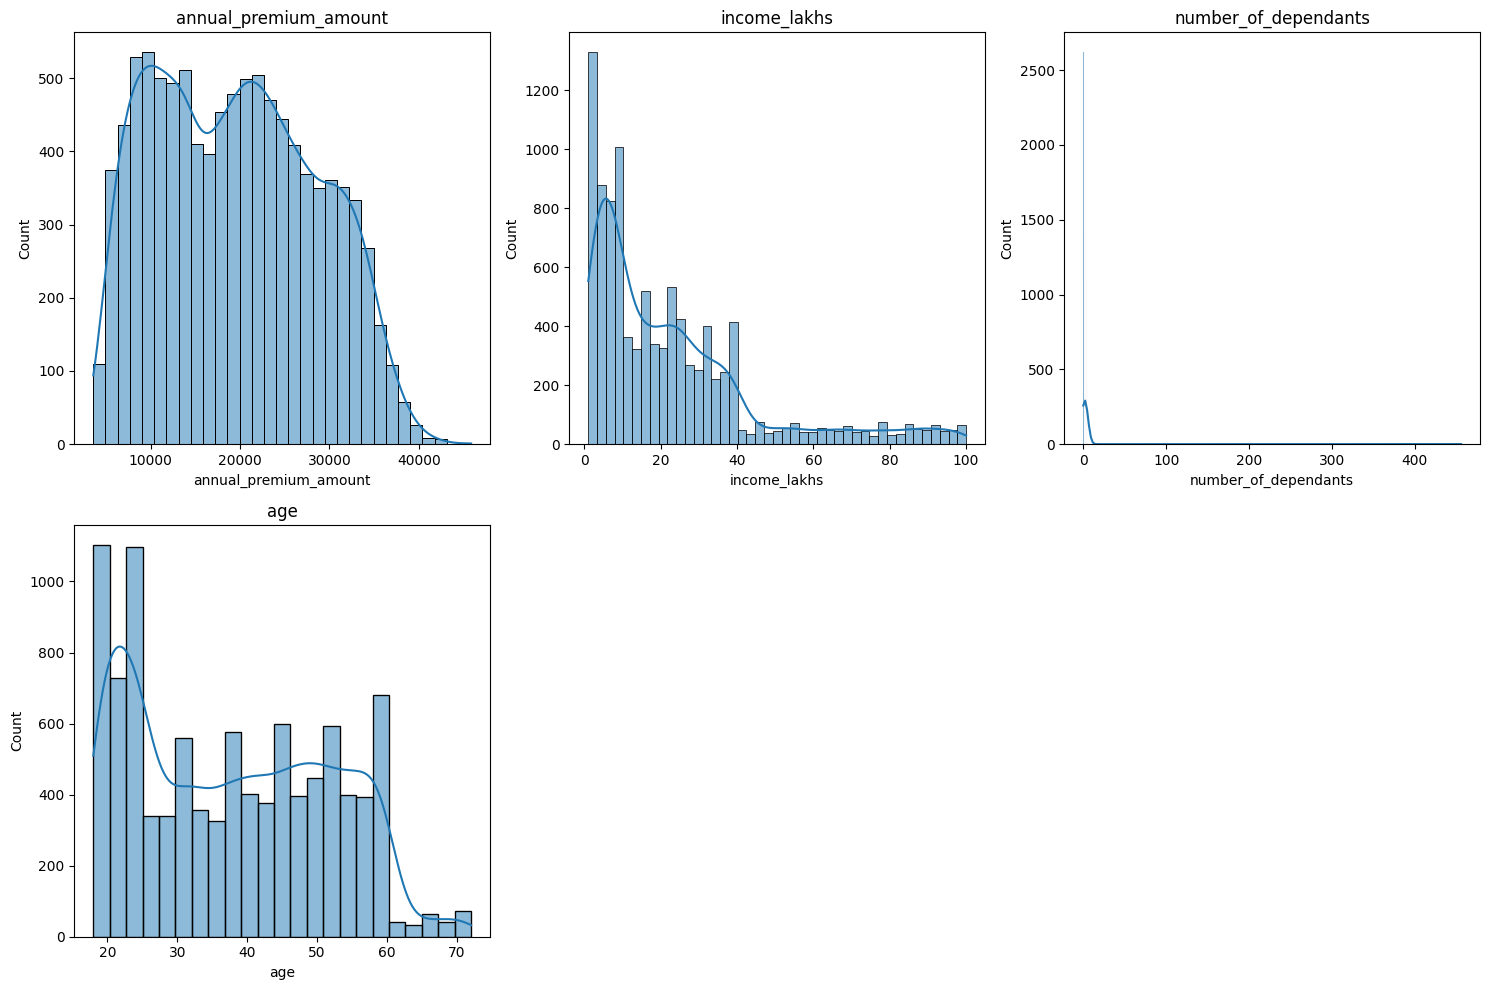

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the size to ensure plots are not squeezed
numeric_columns = ['annual_premium_amount', 'income_lakhs', 'number_of_dependants', 'age']
for i, column in enumerate(numeric_columns):
    # Locating the correct subplot using integer division and modulus
    ax = axs[i // 3, i % 3]  # Row index is i//3, column index is i%3
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

# If the last subplot axis is unused, you can turn it off
if len(numeric_columns) % 3 != 0:
    for j in range(len(numeric_columns), 6):  # This will disable any unused subplots
        axs.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

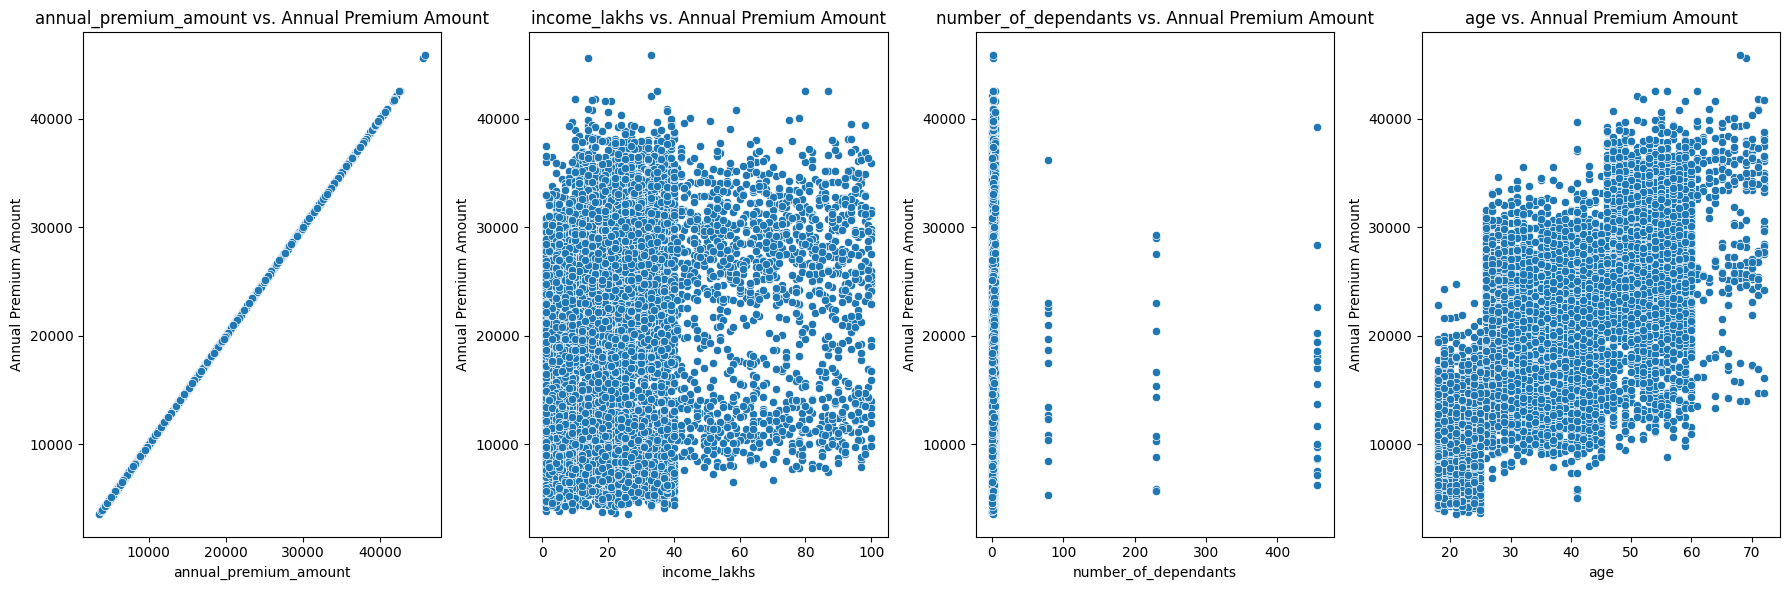

In [20]:
numeric_features = ['annual_premium_amount', 'income_lakhs', 'number_of_dependants', 'age']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [94]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan', 'physical_activity', 'stress_level']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Female' 'Male']
region : ['Southeast' 'Northeast' 'Southwest' 'Northwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Overweight' 'Obesity' 'Underweight']
smoking_status : ['No Smoking' 'Occasional' 'Regular']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['25L - 40L' '10L - 25L' '<10L' '> 40L']
medical_history : ['High blood pressure' 'No Disease' 'Thyroid'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid' 'Diabetes'
 'Heart disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease']
insurance_plan : ['Gold' 'Silver' 'Bronze']
physical_activity : ['Medium' 'Low' 'High']
stress_level : ['Medium' 'High' 'Low']


In [21]:
df2['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

array(['No Smoking', 'Occasional', 'Regular'], dtype=object)

<h2 align="center" style="color:blue">Feature Engineering</h2>

In [22]:
df2.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108


### Calculate Risk Score

In [23]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')
Diseases = ['disease1', 'disease2']
df2['total_risk_score'] = 0
for disease in Diseases:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000


### Encode Text Columns

In [24]:
df2['physical_activity'] = df2['physical_activity'].map({'High': 0,'Low': 4,'Medium': 1})

In [25]:
df2['stress_level'] = df2['stress_level'].map({'High': 4,'Low': 0,'Medium': 1})

In [26]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Gold': 3,'Silver': 2,'Bronze': 1})

In [27]:
df2.income_level.unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L'], dtype=object)

In [28]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [29]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,1,1,2,3,37,High blood pressure,3,27944,high blood pressure,...,1,0,1,0,0,0,0,0,0,1
1,38,4,4,5,2,10,No Disease,2,21108,no disease,...,0,0,0,0,1,0,1,0,0,0
2,18,1,4,0,1,9,No Disease,1,8459,no disease,...,0,1,1,0,0,0,0,0,0,0


In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9963 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              9963 non-null   int64  
 1   physical_activity                9963 non-null   int64  
 2   stress_level                     9963 non-null   int64  
 3   number_of_dependants             9963 non-null   int64  
 4   income_level                     9963 non-null   int64  
 5   income_lakhs                     9963 non-null   int64  
 6   medical_history                  9963 non-null   object 
 7   insurance_plan                   9963 non-null   int64  
 8   annual_premium_amount            9963 non-null   int64  
 9   disease1                         9963 non-null   object 
 10  disease2                         9963 non-null   object 
 11  total_risk_score                 9963 non-null   int64  
 12  normalized_risk_score    

### Feature Selection

In [31]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)                

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,1,1,2,3,37,3,27944,0.428571,0,...,1,0,1,0,0,0,0,0,0,1
1,38,4,4,5,2,10,2,21108,0.000000,0,...,0,0,0,0,1,0,1,0,0,0
2,18,1,4,0,1,9,1,8459,0.000000,0,...,0,1,1,0,0,0,0,0,0,0


### Calculate VIF for Multicolinearity

In [32]:
df4.columns

Index(['age', 'physical_activity', 'stress_level', 'number_of_dependants',
       'income_level', 'income_lakhs', 'insurance_plan',
       'annual_premium_amount', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

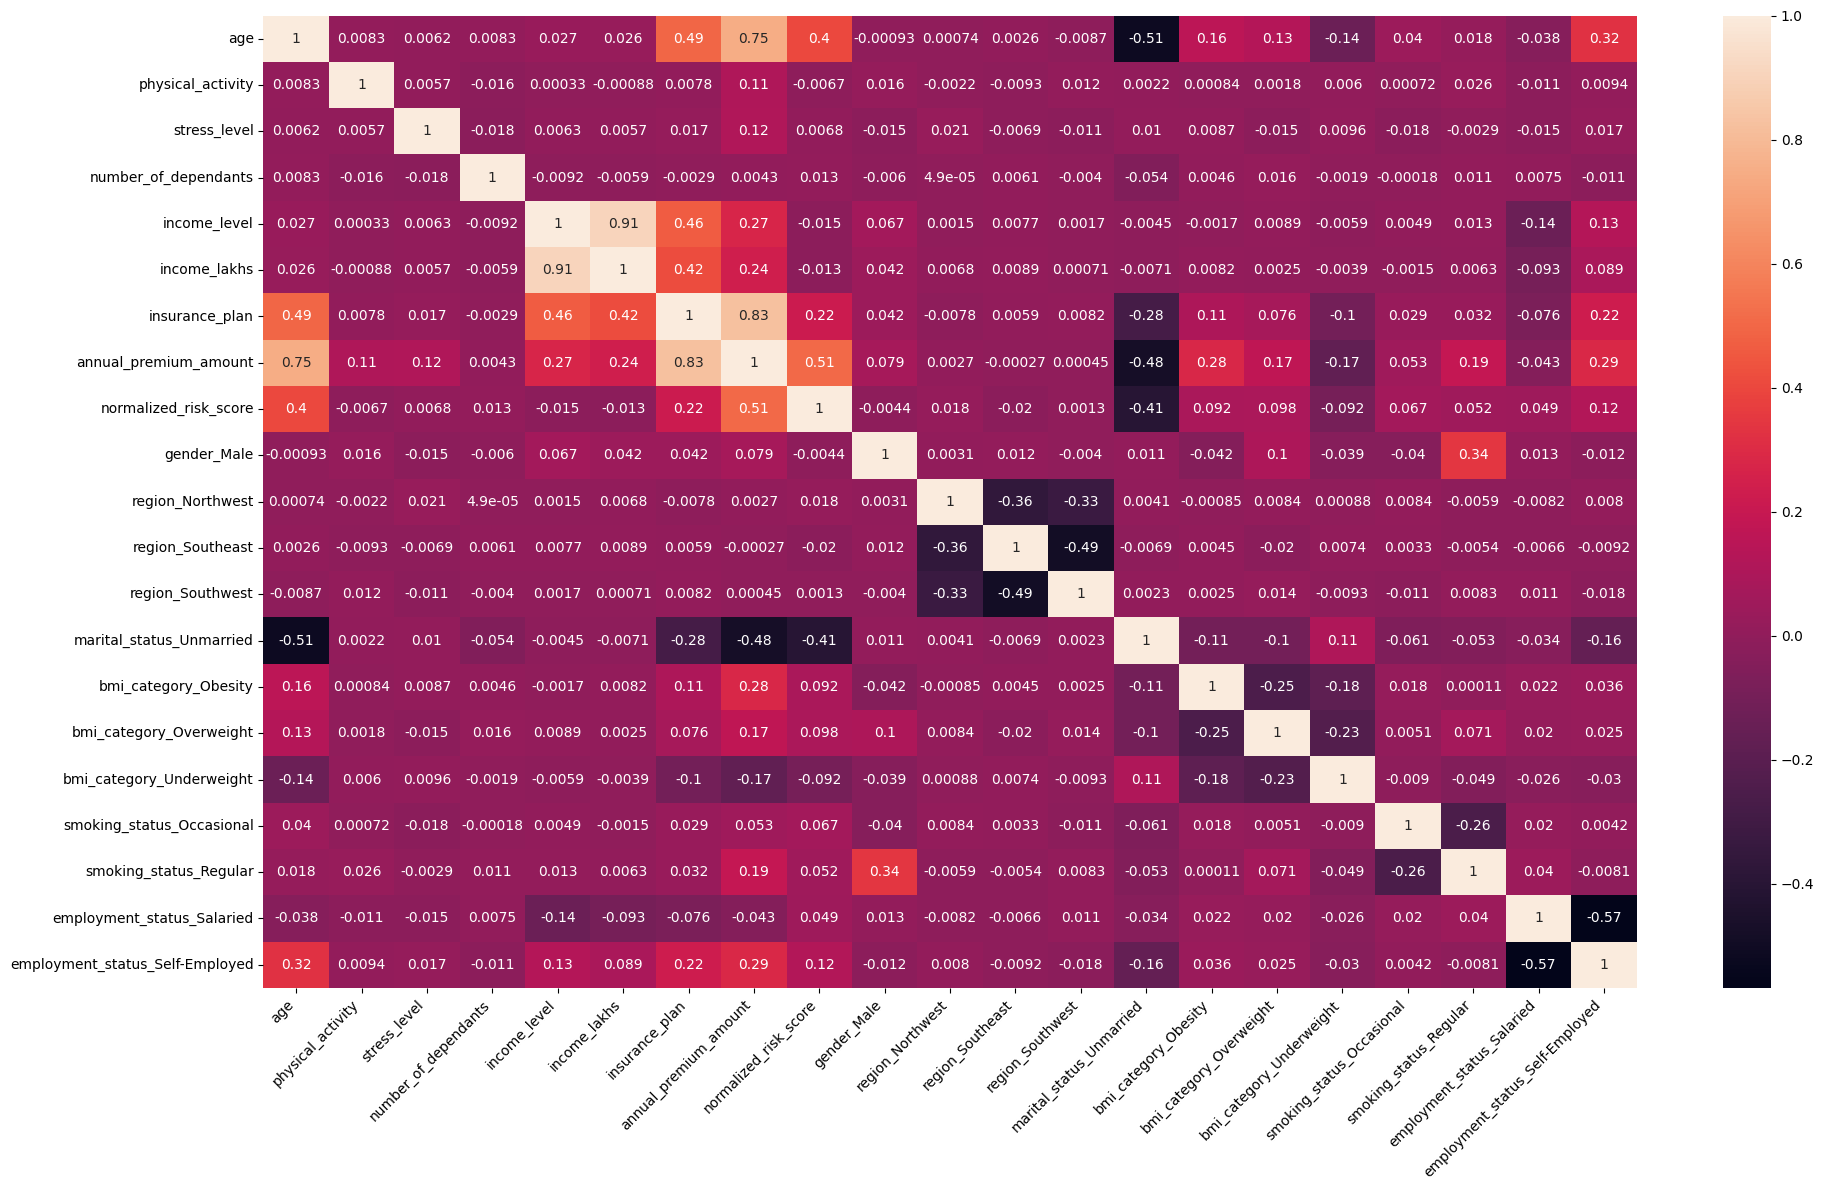

In [33]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [35]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants','income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000,9963.000000
mean,0.366125,1.554753,1.709023,0.007013,0.360467,0.218808,0.445850,0.326429,0.400783,0.194319,0.353207,0.306534,0.438021,0.168524,0.240590,0.141423,0.149854,0.278631,0.420456,0.307538
std,0.258081,1.467129,1.556390,0.047566,0.352063,0.226592,0.395535,0.278953,0.490082,0.395695,0.477990,0.461077,0.496169,0.374349,0.427463,0.348475,0.356947,0.448348,0.493657,0.461497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,1.000000,1.000000,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.351852,1.000000,1.000000,0.004386,0.333333,0.151515,0.500000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.592593,4.000000,4.000000,0.006579,0.666667,0.303030,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
calculate_vif(X)

,Column,VIF
0,age,5.438213
1,physical_activity,2.021724
2,stress_level,2.092391
3,number_of_dependants,1.022661
4,income_level,12.498273
5,income_lakhs,10.942695
6,insurance_plan,4.133536
7,normalized_risk_score,2.911107
8,gender_Male,1.904191
9,region_Northwest,1.906728


In [37]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,5.394021
1,physical_activity,2.021058
2,stress_level,2.091657
3,number_of_dependants,1.022661
4,income_lakhs,2.415362
5,insurance_plan,3.863964
6,normalized_risk_score,2.911009
7,gender_Male,1.894992
8,region_Northwest,1.905424
9,region_Southeast,2.595623


In [38]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

<h2 align="center" style="color:blue">Model Training</h2>

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (6974, 19)
x test:  (2989, 19)
y train:  (6974,)
y test:  (2989,)


### Linear Regression Model

In [40]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9569236011745654, 0.9582265349825903)

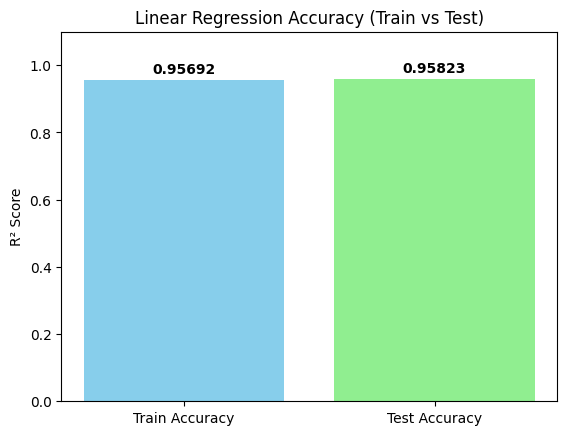

In [41]:
import matplotlib.pyplot as plt

# Scores
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

# Plot
fig, ax = plt.subplots()
ax.bar(['Train Accuracy', 'Test Accuracy'], [train_score, test_score], color=['skyblue', 'lightgreen'])
ax.set_ylim(0, 1.1)
ax.set_ylabel('R² Score')
ax.set_title('Linear Regression Accuracy (Train vs Test)')
for i, v in enumerate([train_score, test_score]):
    ax.text(i, v + 0.02, f"{v:.5f}", ha='center', fontweight='bold')

# Optional: For Streamlit
# st.pyplot(fig)


In [42]:
X_test.shape

(2989, 19)

In [43]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([10737.251827,   593.600386,   592.46684 ,  -213.757055,
        -675.044108, 13220.278834,  6547.97306 ,    73.532808,
         -12.830791,    16.872873,  -108.552937,  -523.74288 ,
        4168.91298 ,  2059.064261,   402.098977,  1178.937803,
        3068.893318,    85.470872,   432.090584])

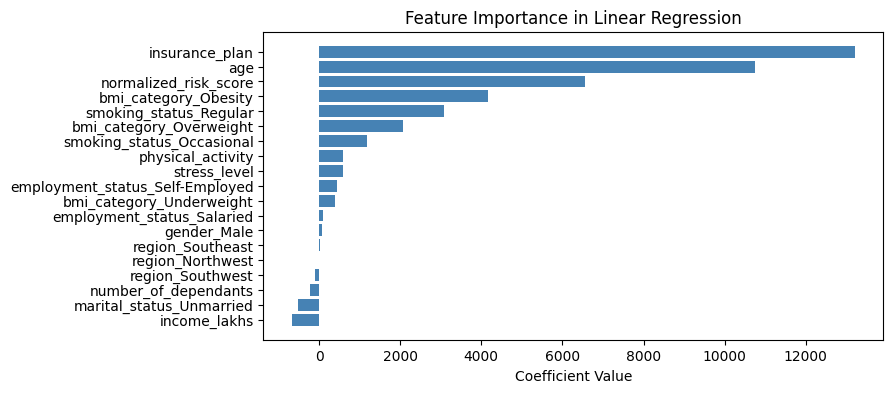

In [44]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### XGBoost Regressor

In [45]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9871103763580322

In [46]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9905954996744791

In [47]:
best_model = model_lr

In [48]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3370,6498,5999.810461,-498.189539,-7.666813
9362,21800,23475.119777,1675.119777,7.684036
6372,10965,12137.542053,1172.542053,10.693498
1635,15253,18775.080118,3522.080118,23.091065
6482,7581,5689.184664,-1891.815336,-24.954694


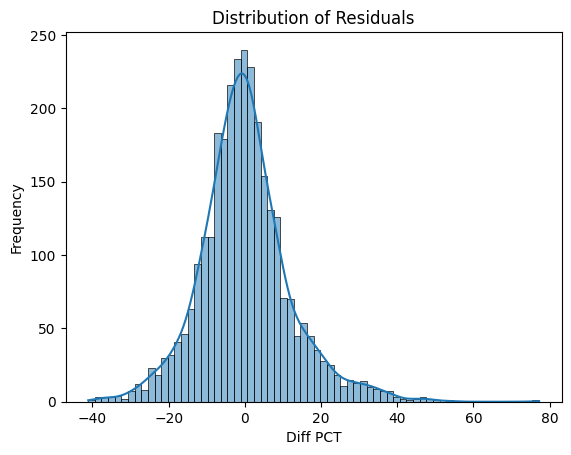

In [49]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [47]:
X_test.shape

(6026, 18)

In [50]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
6372,10965,12137.542053,1172.542053,10.693498
1635,15253,18775.080118,3522.080118,23.091065
6482,7581,5689.184664,-1891.815336,-24.954694
1492,15156,18195.629130,3039.629130,20.055616
2946,10775,13180.660218,2405.660218,22.326313


In [51]:
extreme_results_df.shape

(948, 4)

In [52]:
extreme_results_df.shape[0]*100/X_test.shape[0]

31.71629307460689

We now have only 2% extreme errors.

In [51]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.0,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.0,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0


### Export the Model

In [53]:
from joblib import dump

dump(best_model, "artifacts/model_young.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts/scaler_young.joblib")

FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/model_young.joblib'